# Imports and initilizations 

In [1]:
from google.colab import drive
drive.mount('/content/drive')



#Importing data from kaggle settings
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download amitabhajoy/bengaluru-house-price-data
! unzip bengaluru-house-price-data.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists
bengaluru-house-price-data.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bengaluru-house-price-data.zip
replace Bengaluru_House_Data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [2]:
#Libraries - basic
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams["figure.figsize"] = (20,10)
import seaborn as sns
import missingno as msno #Heatmap
import warnings
warnings.filterwarnings('ignore')

#Scikitlearn
import sklearn
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


#ANN
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout

import pickle
pd.set_option('display.max_rows', None)

In [3]:
prices_df=pd.read_csv("Bengaluru_House_Data.csv")
prices_df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


# Data preprocessing

In [4]:
print(f'shape: {prices_df.shape}\n\ndescription: {prices_df.describe()}\n\n columns:\n{prices_df.columns}')

shape: (13320, 9)

description:                bath       balcony         price
count  13247.000000  12711.000000  13320.000000
mean       2.692610      1.584376    112.565627
std        1.341458      0.817263    148.971674
min        1.000000      0.000000      8.000000
25%        2.000000      1.000000     50.000000
50%        2.000000      2.000000     72.000000
75%        3.000000      2.000000    120.000000
max       40.000000      3.000000   3600.000000

 columns:
Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')


In [5]:
prices_df.loc[:, prices_df.isnull().any()].count()

location    13319
size        13304
society      7818
bath        13247
balcony     12711
dtype: int64

<AxesSubplot:>

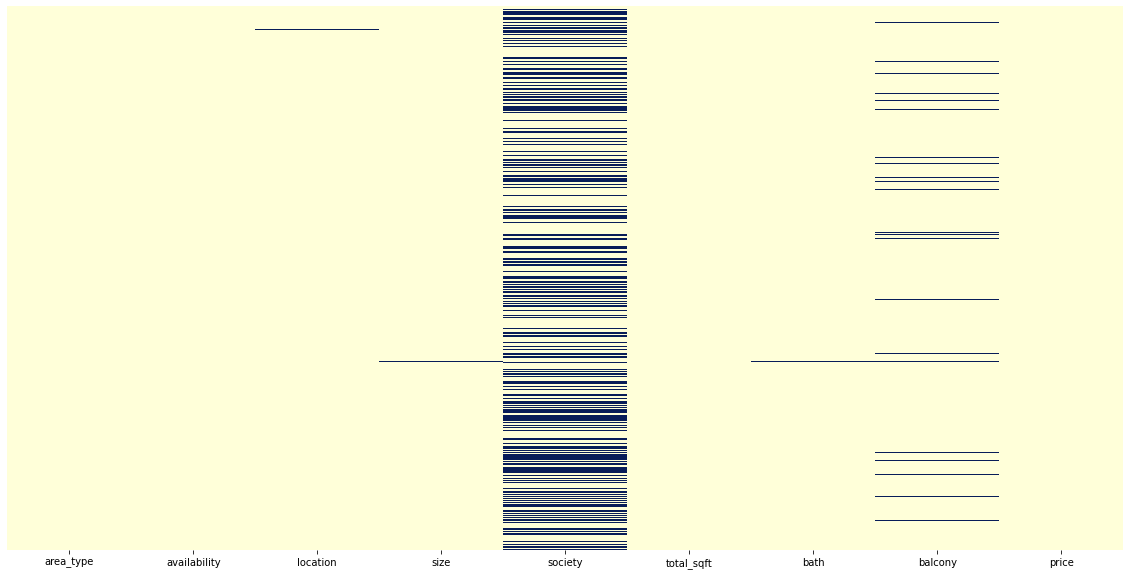

In [6]:
sns.heatmap(prices_df.isnull(),yticklabels=False,cbar=False,cmap='YlGnBu')

* Dropping less important features

In [7]:
prices_df.drop(["area_type", "society","balcony", "availability"], axis = 1,inplace=True)

In [8]:
prices_df.shape

(13320, 5)

In [9]:
prices_df.loc[:, prices_df.isnull().any()].count()

location    13319
size        13304
bath        13247
dtype: int64

In [10]:
prices_df = prices_df.dropna()
print(f'NULL values: {prices_df.loc[:, prices_df.isnull().any()].count()}, shape: {prices_df.shape}')


NULL values: Series([], dtype: int64), shape: (13246, 5)


* Feature Engineering

In [11]:
prices_df["size"].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

We notice that we have numerical and categorical values seperated by spaces, hence we use split function to consider the numerical values only.

In [12]:
#BHK column refers to "Bedrooms/ Hall/ Kitchen"
prices_df['BHK'] = prices_df["size"].apply(lambda x: int(x.split(" ")[0]))

In [13]:
print(prices_df.head())
print(f'Numbers of unique BHK: {sorted(prices_df.BHK.unique())}')

                   location       size total_sqft  bath   price  BHK
0  Electronic City Phase II      2 BHK       1056   2.0   39.07    2
1          Chikka Tirupathi  4 Bedroom       2600   5.0  120.00    4
2               Uttarahalli      3 BHK       1440   2.0   62.00    3
3        Lingadheeranahalli      3 BHK       1521   3.0   95.00    3
4                  Kothanur      2 BHK       1200   2.0   51.00    2
Numbers of unique BHK: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 19, 27, 43]


* Exploring the non-numerical data through the funciton we made, which return true on floats values, thus we can print all the non-float values utilizing the "~" sign and applying the function.

In [14]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [15]:
prices_df[~prices_df['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,BHK
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


In [16]:
# This function takes the col's values as an argument and returns the mean
def convert_sqft_to_number(x):
    tokens = x.split("-")
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [17]:
prices_df["total_sqft"] = prices_df["total_sqft"].apply(convert_sqft_to_number)

In [18]:
#printing the row № 30,410 cause it had the non-float value (mentiond above)
print(f'{prices_df.loc[30]}, {prices_df.loc[410]}')

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
BHK                   4
Name: 30, dtype: object, location      Kengeri
size            1 BHK
total_sqft        NaN
bath              1.0
price            18.5
BHK                 1
Name: 410, dtype: object


In [19]:
# Creating a new feature considering that prices in Rupee
# We created this feature to have an wide observation about the outliers
prices_df["price_per_sqft"] = prices_df["price"]*100000/prices_df["total_sqft"]
prices_df.head()

,location,size,total_sqft,bath,price,BHK,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


* Using dimension reduction

In [20]:
# here we apply lambda to strip any leading or trailing whitespaces in the 'location' column 
# of the DataFrame 'prices_df' before computing the value counts.
prices_df['location'] = prices_df['location'].apply(lambda x: x.strip())
location_stats = prices_df['location'].value_counts(ascending=False)
print(location_stats)

Whitefield                                            535
Sarjapur  Road                                        392
Electronic City                                       304
Kanakpura Road                                        266
Thanisandra                                           236
Yelahanka                                             210
Uttarahalli                                           186
Hebbal                                                176
Marathahalli                                          175
Raja Rajeshwari Nagar                                 171
Bannerghatta Road                                     152
Hennur Road                                           150
7th Phase JP Nagar                                    149
Haralur Road                                          141
Electronic City Phase II                              131
Rajaji Nagar                                          106
Chandapura                                             98
Bellandur     

In [21]:
print(f'The length of the location_stats feature is: {len(location_stats)} ')

The length of the location_stats feature is: 1293 


In [22]:
len(location_stats[location_stats<=10])

1052

In [23]:
location_stats_less_than_10 = location_stats[location_stats<=10]
print(location_stats_less_than_10)

Naganathapura                                         10
Sadashiva Nagar                                       10
Nagappa Reddy Layout                                  10
BTM 1st Stage                                         10
Sector 1 HSR Layout                                   10
Basapura                                              10
Ganga Nagar                                           10
Dairy Circle                                          10
Kalkere                                               10
1st Block Koramangala                                 10
Dodsworth Layout                                      10
Nagadevanahalli                                       10
Gunjur Palya                                          10
2nd Phase JP Nagar                                     9
KUDLU MAIN ROAD                                        9
4th Block Koramangala                                  9
Vignana Nagar                                          9
Ejipura                        

In [24]:
prices_df['location']=prices_df['location'].apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(prices_df['location'].unique())

242

In [25]:
prices_df.head()

,location,size,total_sqft,bath,price,BHK,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


* Outliers removal utilizing business principles 

In [26]:
print(f"{prices_df[(prices_df['total_sqft']/prices_df['BHK'])<300].head()}\n\n{len(prices_df[(prices_df['total_sqft']/prices_df['BHK'])<300])}")


               location       size  total_sqft  bath  price  BHK  \
9                 other  6 Bedroom      1020.0   6.0  370.0    6   
45           HSR Layout  8 Bedroom       600.0   9.0  200.0    8   
58        Murugeshpalya  6 Bedroom      1407.0   4.0  150.0    6   
68  Devarachikkanahalli  8 Bedroom      1350.0   7.0   85.0    8   
70                other  3 Bedroom       500.0   3.0  100.0    3   

    price_per_sqft  
9     36274.509804  
45    33333.333333  
58    10660.980810  
68     6296.296296  
70    20000.000000  

744


In [27]:
# Through this feature we observer that the max value is so high
print(prices_df['price_per_sqft'].describe())
print(f'\n\n{prices_df.shape}')

count    1.320000e+04
mean     7.920759e+03
std      1.067272e+05
min      2.678298e+02
25%      4.267701e+03
50%      5.438331e+03
75%      7.317073e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64


(13246, 7)


In [28]:
# Thus we try to remove outliers using mean and std values
def remove_outliers(df):
    df_output = pd.DataFrame()
    for key, sub_df in df.groupby('location'):
        mean = np.mean(sub_df['price_per_sqft'])
        std = np.std(sub_df['price_per_sqft'])
        reduced_df = sub_df[(sub_df['price_per_sqft']>(mean-std)) & (sub_df['price_per_sqft']<=(mean+std))]
        df_output = pd.concat([df_output,reduced_df],ignore_index=True)
    return df_output
prices_df = remove_outliers(prices_df)
prices_df.shape

(11428, 7)

Here we try to check the logic, for instance if the house has 2 BHK has high value than the house with 3 of them.

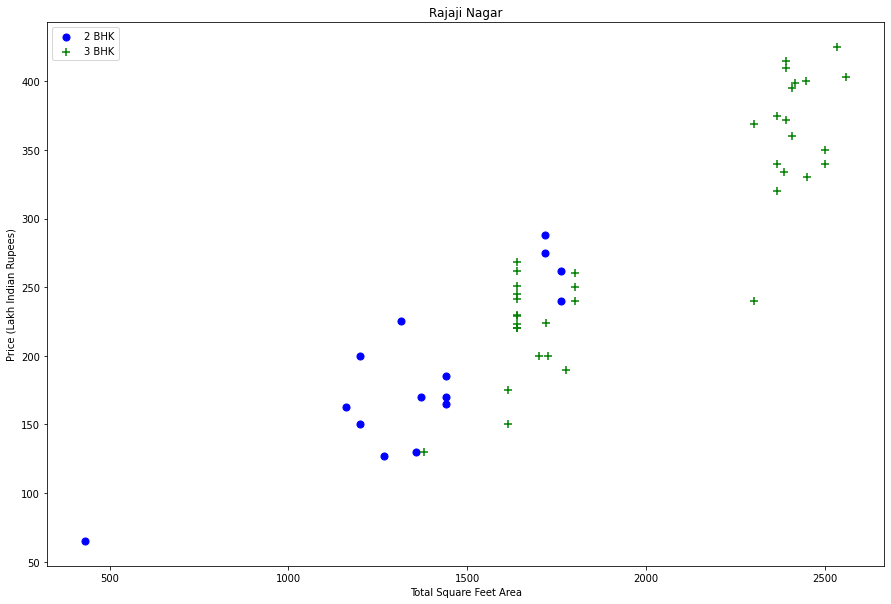

In [29]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.BHK==2)]
    bhk3 = df[(df.location==location) & (df.BHK==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()

plot_scatter_chart(prices_df,"Rajaji Nagar")

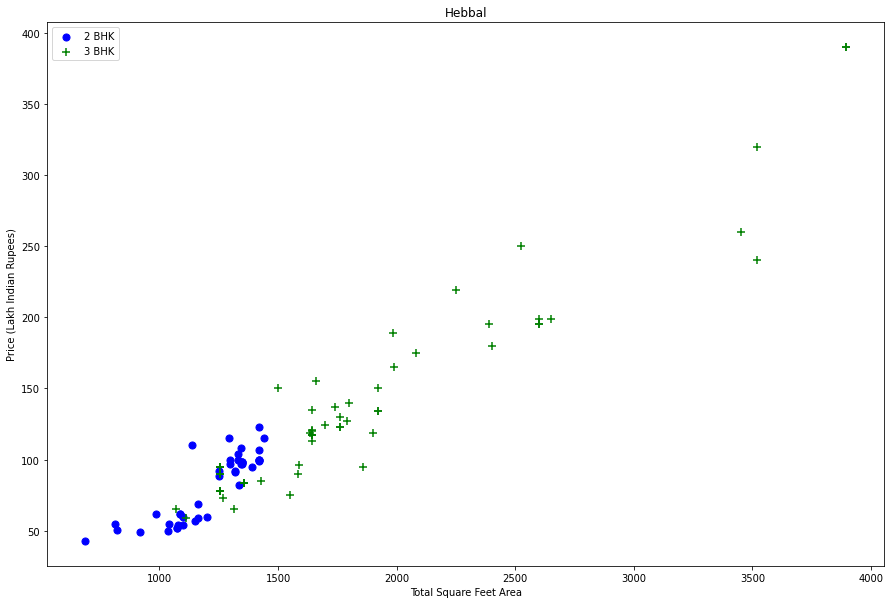

In [30]:
plot_scatter_chart(prices_df,"Hebbal")

In [31]:
# This function removes the BHK houses if they are below BHK-1 mean 
def remove_bhk_outliers(df):
    exclude_indices = np.array([])

    for location, location_df in df.groupby('location'):
        bhk_stats = {}

        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = \
            {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }

        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)

    return df.drop(exclude_indices,axis='index')

In [32]:
print(prices_df.shape)
prices_df=remove_outliers(prices_df)
print(prices_df.shape)

(11428, 7)
(8333, 7)


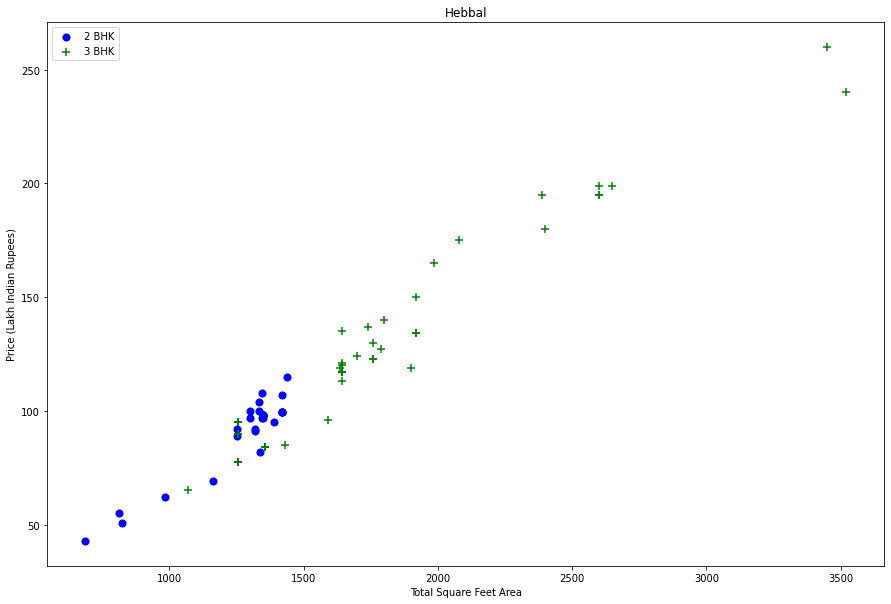

In [33]:
plot_scatter_chart(prices_df,"Hebbal")

Through the chart above we observer that some of the outliers has been removed

Text(0, 0.5, 'Count')

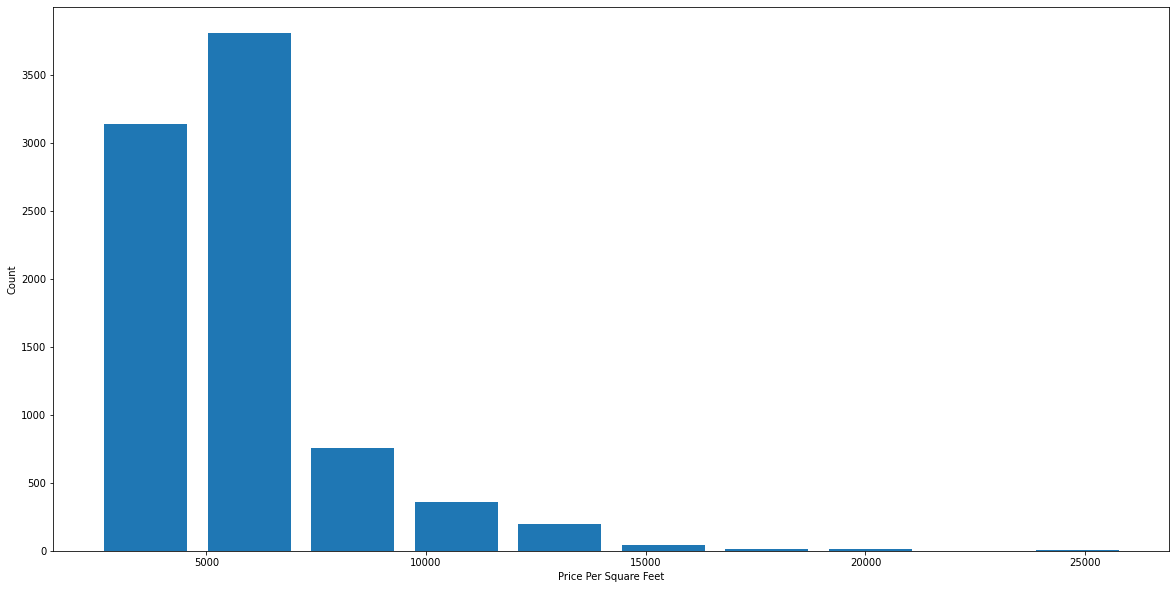

In [34]:
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(prices_df['price_per_sqft'],rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

In [35]:
# Checking number of bathrooms
print(sorted(prices_df['bath'].unique()))

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 12.0, 13.0, 15.0, 16.0, 27.0]


It's uncommon to have 3 more bathrooms than the number of bedrooms in a house, thus we gonna filter the data based on this fact.

In [36]:
print(prices_df.shape)
prices_df=prices_df[prices_df['bath']<prices_df['BHK']+2]
print(prices_df.shape)

(8333, 7)
(8255, 7)


In [37]:
prices_df.drop(['size','price_per_sqft'],axis='columns',inplace=True)
prices_df.head()

,location,total_sqft,bath,price,BHK
0,1st Block Jayanagar,1630.0,3.0,194.0,3
1,1st Block Jayanagar,1875.0,2.0,235.0,3
2,1st Block Jayanagar,1200.0,2.0,130.0,3
3,1st Block Jayanagar,1235.0,2.0,148.0,2
4,1st Phase JP Nagar,2825.0,4.0,250.0,4


In [38]:
#Onehot_encoding
def onehot_encoding(final_df,cat_columns):
    encoded_df=final_df
    i=0
    for column in cat_columns:
        print(column)
        df1=pd.get_dummies(final_df[column],drop_first=True)
        final_df.drop([column],axis=1,inplace=True)
        if i==0:
             encoded_df=df1.copy()
        else:     
             encoded_df=pd.concat([ encoded_df,df1],axis=1)
        i=i+1
       
    encoded_df=pd.concat([final_df, encoded_df],axis=1)
        
    return encoded_df

In [39]:
prices_df=onehot_encoding(prices_df,['location'])

location


In [40]:
prices_df=prices_df.loc[:,~prices_df.columns.duplicated()] #Remove duplicated columns

In [41]:
prices_df.head()

,total_sqft,bath,price,BHK,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1630.0,3.0,194.0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1875.0,2.0,235.0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1200.0,2.0,130.0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1235.0,2.0,148.0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2825.0,4.0,250.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
X = prices_df.drop(['price'],axis='columns')
y = prices_df['price']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [44]:
X_train.shape

(6604, 244)

# ML

In [ ]:
# Define the models and their hyperparameters
model_params = {
    'xgb_regressor' : {
        'model': XGBRegressor(),
        'params':{
            'objective':['reg:squarederror'],
            'n_estimators': [100, 900, 1500],
            'max_depth':[2, 3, 5, 10, 15],
            'learning_rate':[0.025,0.1,0.15,0.20],
            'min_child_weight':[1,2,3,4],
            'booster':['gbtree','gblinear'],
            'base_score':[0.25,0.5,0.75,1]
        }
    },
    'random_forest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [10, 50, 100],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'linear_regression': {
        'model': LinearRegression(),
        'params': {
            'normalize': [True, False]
        }
    },
    'decision_tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'criterion': ['mse', 'friedman_mse'],
            'splitter': ['best', 'random'],
            'max_depth': [None, 10, 20]
        }
    },
    'lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [1,2],
            'selection': ['random', 'cyclic']
        }
    }
}

# Run a grid search to find the best hyperparameters for each model
best_scores = []
for model_name, mp in model_params.items():
    clf = RandomizedSearchCV(mp['model'], mp['params'], cv=5, random_state=42)
    clf.fit(X_train, y_train)
    best_scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

# Find the best algorithm
best_model_name = max(best_scores, key=lambda x: x['best_score'])['model']
print("Best algorithm:", best_model_name)

# Get the best model object and its parameters
best_model = model_params[best_model_name]['model']
best_params = next(item for item in best_scores if item['model'] == best_model_name)['best_params']

# Fit the best algorithm into the pipeline
steps = [('imputer', SimpleImputer()), 
         ('scaler', StandardScaler()), 
         (best_model_name, best_model.set_params(**best_params))]

pipeline = Pipeline(steps)

pipeline.fit(X_train, y_train)

# Fit the pipeline and compute its evaluation metric
if best_model_name == 'linear_regression':
    predictions = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    print("MSE:", mse)
else:
    score = pipeline.score(X_test, y_test)
    print("Score:", score)

#pd.DataFrame(scores,columns=['model','best_score','best_params'])

# AI

In [47]:
# Initialising the Artifical Neural Network
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(50, kernel_initializer = 'he_uniform',activation='relu',input_dim = 244))

# Adding the second hidden layer
classifier.add(Dense(50, kernel_initializer = 'he_uniform',activation='relu'))

# Adding the third hidden layer
classifier.add(Dense(50, kernel_initializer = 'he_uniform',activation='relu'))
# Adding the output layer
classifier.add(Dense(1, kernel_initializer = 'he_uniform'))

# Compiling the ANN
classifier.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='Adamax')

# Fitting the ANN to the Training set
model_history=classifier.fit(X_train.values, y_train.values,validation_split=0.20, batch_size = 10, epochs = 500)

Epoch 1/500
529/529 [==============================] - 9s 12ms/step - loss: 2021.2173 - val_loss: 1583.3829
Epoch 2/500
529/529 [==============================] - 4s 7ms/step - loss: 1938.0420 - val_loss: 1579.9148
Epoch 3/500
529/529 [==============================] - 3s 6ms/step - loss: 1939.7906 - val_loss: 1833.2551
Epoch 4/500
529/529 [==============================] - 1s 3ms/step - loss: 1966.6843 - val_loss: 1564.8011
Epoch 5/500
529/529 [==============================] - 2s 3ms/step - loss: 1928.4785 - val_loss: 1609.2953
Epoch 6/500
529/529 [==============================] - 2s 4ms/step - loss: 1913.0165 - val_loss: 1568.5748
Epoch 7/500
529/529 [==============================] - 2s 4ms/step - loss: 1926.4098 - val_loss: 1604.8024
Epoch 8/500
529/529 [==============================] - 2s 4ms/step - loss: 1883.5819 - val_loss: 1602.0261
Epoch 9/500
529/529 [==============================] - 1s 3ms/step - loss: 1924.7009 - val_loss: 1580.9329
Epoch 10/500
529/529 [==============

In [58]:
#Testing the model
def predict_price(classifier, location, sqft, bath, bhk):
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    # Reshape the array to (1, len(X.columns))
    x = x.reshape(1, -1)

    return classifier.predict(x)[0]

In [59]:
print(f'Best_algo prediciton:{predict_price(pipeline,"1st Phase JP Nagar",1000, 2, 2)}')
print(f'ANN prediciton:{predict_price(classifier,"1st Phase JP Nagar",1000, 2, 2)}')

Best_algo prediciton:91.46317348473669
1/1 [==============================] - 1s 706ms/step
ANN prediciton:[88.058304]


In [64]:
print(f'Best_algo prediciton:{predict_price(pipeline,"Indira Nagar",1000, 3, 3)}')
print(f'ANN prediciton:{predict_price(classifier,"Indira Nagar",1000, 3, 3)}')

Best_algo prediciton:145.46099244754637
1/1 [==============================] - 0s 122ms/step
ANN prediciton:[136.57008]


ANN output seems more rational, thus we going to export it

# Exporting

In [65]:
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(classifier,f)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-02-28 13:17:45         2389
variables.h5                                   2023-02-28 13:17:45       235328
metadata.json                                  2023-02-28 13:17:45           64


In [66]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))